In [3]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
from shapely.geometry import Point

import sys
sys.path.append('../../')
import snowFun
# %matplotlib widget

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_climate = os.path.join(folder_AGVA, "Climate")

In [43]:
# open rgi attribute table, subsetting to the columns we want
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_df = gpd.read_file(path_rgi, include_fields=["RGIId","CenLon","CenLat",'Area'])

# path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
# # path_rgi = os.path.join(folder_AGVA, 'RGI', "RGI_v70", "RGI2000-v7.0-G-01_alaska", "RGI2000-v7.0-G-01_alaska-attributes.csv")
# rgi_df = pd.read_csv(path_rgi, usecols=["rgi_id","cenlon","cenlat","area_km2","zmed_m","zmean_m"])
print(rgi_df.shape)
rgi_df.head()

(3031, 5)


,RGIId,CenLon,CenLat,Area,geometry
0,RGI60-01.00004,-146.120,63.381,3.681,"POLYGON ((390852.892 1513270.533, 390859.011 1..."
1,RGI60-01.00005,-147.057,63.551,2.573,"POLYGON ((344516.095 1527311.059, 344445.809 1..."
2,RGI60-01.00006,-146.244,63.571,10.470,"POLYGON ((383858.051 1532357.663, 383852.553 1..."
3,RGI60-01.00010,-147.170,63.513,3.806,"POLYGON ((339736.019 1522275.072, 339760.103 1..."
4,RGI60-01.00012,-146.651,63.366,2.802,"POLYGON ((367276.652 1509860.919, 367276.151 1..."


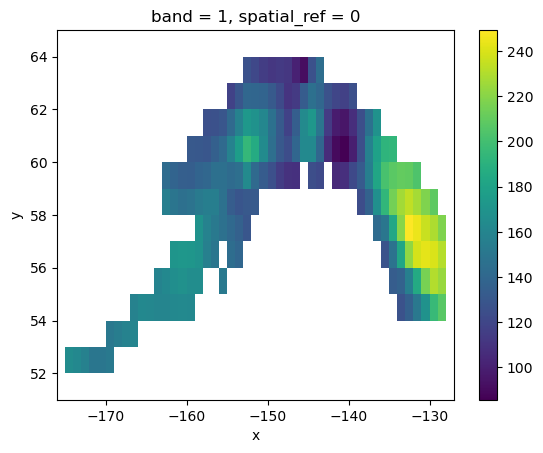

In [9]:
# open the future ELA changes
path_open = os.path.join(folder_climate, 'CMIP', "delta_ELA.tif")

delta_ela = riox.open_rasterio(path_open)
delta_ela.plot()

In [44]:
# for each rgi, extract delta ela from closest cmip gridcell, save to csv
c=0
n=len(rgi_df)
delas = []
for idx, row in rgi_df.iterrows():
    c+=1 
        
    rgi_id = row['RGIId']
    cenlon = row['CenLon']
    cenlat = row['CenLat']
    
    dela = delta_ela.sel(x=cenlon, y=cenlat, method="nearest").values[0]
    delas.append(round(dela))

rgi_df['delta_ela'] = delas

out_path = os.path.join(folder_climate, 'CMIP', "rgi_delta_ELA.csv")
out_df = rgi_df[["RGIId", 'delta_ela']]
out_df.to_csv(out_path, index=False)

In [45]:
rgi_df.head()

,RGIId,CenLon,CenLat,Area,geometry,delta_ela
0,RGI60-01.00004,-146.120,63.381,3.681,"POLYGON ((390852.892 1513270.533, 390859.011 1...",101
1,RGI60-01.00005,-147.057,63.551,2.573,"POLYGON ((344516.095 1527311.059, 344445.809 1...",112
2,RGI60-01.00006,-146.244,63.571,10.470,"POLYGON ((383858.051 1532357.663, 383852.553 1...",101
3,RGI60-01.00010,-147.170,63.513,3.806,"POLYGON ((339736.019 1522275.072, 339760.103 1...",112
4,RGI60-01.00012,-146.651,63.366,2.802,"POLYGON ((367276.652 1509860.919, 367276.151 1...",101


In [55]:
rgi_df['area_norm'] = rgi_df['Area']/np.nansum(rgi_df['Area'])
print("Mean glacier ELA rise:", np.nanmean(rgi_df['delta_ela']))
print("Area-averaged ELA rise:", np.nansum(rgi_df['area_norm']*rgi_df['delta_ela']))
print()
print("Percentiles of glacier-specific ELA rise:")
print("00:", round( np.nanpercentile(rgi_df['delta_ela'], [0])[0] ) )
print("05:", round( np.nanpercentile(rgi_df['delta_ela'], [5])[0] ) )
print("25:", round( np.nanpercentile(rgi_df['delta_ela'], [25])[0] ) )
print("50:", round( np.nanpercentile(rgi_df['delta_ela'], [50])[0] ) )
print("75:", round( np.nanpercentile(rgi_df['delta_ela'], [75])[0] ) )
print("95:", round( np.nanpercentile(rgi_df['delta_ela'], [95])[0] ) )
print("100:", round( np.nanpercentile(rgi_df['delta_ela'], [100])[0] ) )
print()
print("")

Mean glacier ELA rise: 168.8132629495216
Area-averaged ELA rise: 143.48302164963556

Percentiles of glacier-specific ELA rise:
00: 86
05: 98
25: 131
50: 162
75: 214
95: 245
100: 249


Text(0, 0.5, 'ELA Rise')

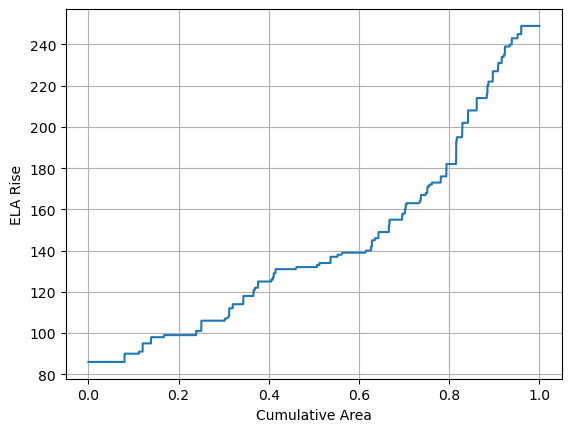

In [63]:
rgi_df_copy = rgi_df.copy()
rgi_df_copy = rgi_df_copy.sort_values('delta_ela')
rgi_df_copy['cumulative_area_norm'] = rgi_df_copy['area_norm'].cumsum()

fig,axs = plt.subplots()
axs.plot(rgi_df_copy['cumulative_area_norm'],rgi_df_copy['delta_ela'])
axs.grid()
axs.set_xlabel("Cumulative Area")
axs.set_ylabel("ELA Rise")

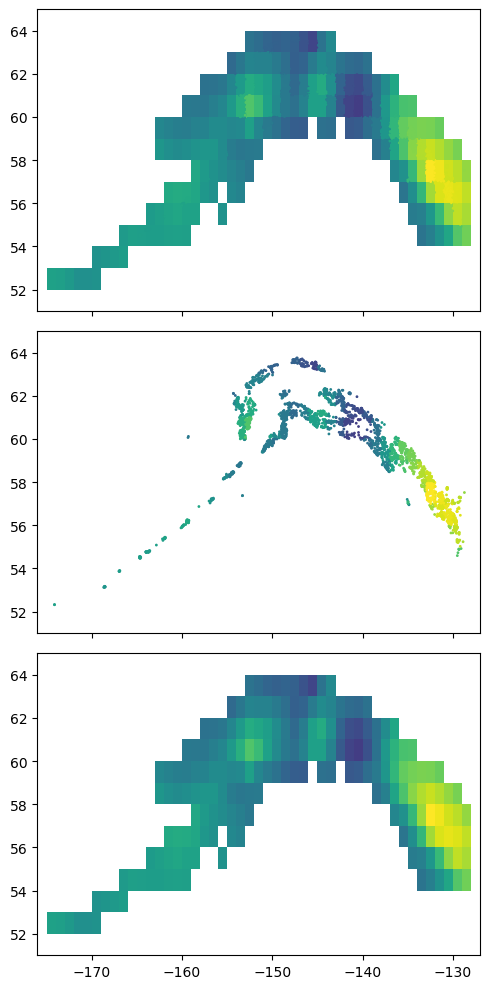

In [41]:
fig,axs=plt.subplots(3,1, figsize=(5,10), sharex=True, sharey=True)

delta_ela.plot(ax=axs[0],vmin=50,vmax=250,add_colorbar=False)
axs[0].scatter(rgi_df['CenLon'],rgi_df['CenLat'],c=rgi_df['delta_ela'],vmin=50,vmax=250,s=1)

axs[1].scatter(rgi_df['CenLon'],rgi_df['CenLat'],c=rgi_df['delta_ela'],vmin=50,vmax=250,s=1)

delta_ela.plot(ax=axs[2],vmin=50,vmax=250,add_colorbar=False)

for ax in axs:
    ax.set_title(None)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
plt.tight_layout()

In [14]:
 
# out_df = pd.DataFrame({'rgi_id':rgi_id,'date':dates,'t':temps,'p':precips, 'z_era5land':z, "zmed_m":z_med})
# out_path = os.path.join(folder_climate, "csv", 'daily', f'{rgi_id}.csv')
    
#     out_df.to_csv(out_path, index=False)